In [1]:
import pybullet as p
import pybullet_data
import time
import numpy as np
import cvxpy as cp
import threading
import random
import tkinter as tk
from tkinter import messagebox
from tkinter import Tk, Label, IntVar, Scale, HORIZONTAL
from tkinter import Tk, Canvas, Label

pybullet build time: Nov 28 2023 23:45:17


In [2]:
import xml.etree.ElementTree as ET

def parse_collision_boxes(urdf_file):
    # Parse the URDF file
    tree = ET.parse(urdf_file)
    root = tree.getroot()

    boxes = []
    
    for link in root.findall("link"):
        for collision in link.findall("collision"):
            geometry = collision.find("geometry")
            box = geometry.find("box")
            if box is not None:
                size = list(map(float, box.attrib["size"].split()))
                origin_elem = collision.find("origin")
                if origin_elem is not None:
                    origin = list(map(float, origin_elem.attrib["xyz"].split()))
                    rpy = list(map(float, origin_elem.attrib["rpy"].split()))
                else:
                    origin = [0.0, 0.0, 0.0]
                    rpy = [0.0, 0.0, 0.0]
                boxes.append((size, origin, rpy))
    return boxes

def compute_min_max(size, origin, rpy):
    # Unpack size and origin
    sx, sy, sz = size
    ox, oy, oz = origin
    
    # Half extents
    hx, hy, hz = sx / 2, sy / 2, sz / 2
    
    # Define corners of the box relative to origin
    corners = np.array([
        [-hx, -hy, -hz],
        [-hx, -hy, hz],
        [-hx, hy, -hz],
        [-hx, hy, hz],
        [hx, -hy, -hz],
        [hx, -hy, hz],
        [hx, hy, -hz],
        [hx, hy, hz],
    ])
    
    # Rotation matrix for z-axis only (rpy[2])
    theta = rpy[2]
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    # Rotate and translate corners
    transformed_corners = np.dot(corners, rotation_matrix.T) + np.array([ox, oy, oz])
    
    # Get min and max
    min_coords = transformed_corners.min(axis=0)
    max_coords = transformed_corners.max(axis=0)
    
    return min_coords, max_coords

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

def plot_3d_boxes(mins, maxs):
    """
    Visualizes 3D bounding boxes defined by mins and maxs with random colors.
    
    Args:
    mins: List of np.array, where each element is a vector [x_min, y_min, z_min] of a bounding box.
    maxs: List of np.array, where each element is a vector [x_max, y_max, z_max] of a bounding box.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    def draw_box(min_point, max_point, ax):
        """Draw a single 3D box on the ax."""
        # Get the 8 corners of the box
        x_min, y_min, z_min = min_point
        x_max, y_max, z_max = max_point
        
        # Define the vertices of the 3D box (corners)
        vertices = np.array([[x_min, y_min, z_min],
                             [x_max, y_min, z_min],
                             [x_max, y_max, z_min],
                             [x_min, y_max, z_min],
                             [x_min, y_min, z_max],
                             [x_max, y_min, z_max],
                             [x_max, y_max, z_max],
                             [x_min, y_max, z_max]])

        # List of the 12 edges (pairs of indices to connect)
        edges = [[0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
                 [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
                 [0, 4], [1, 5], [2, 6], [3, 7]]  # Vertical edges

        # Plot the edges of the box
        for edge in edges:
            ax.plot3D(*zip(*vertices[edge]), color=random_color(), linewidth=2)

    # Plot each box with a random color
    for i in range(len(mins)):
        draw_box(mins[i], maxs[i], ax)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Bounding Boxes')
    ax.set_zlim((0, 2))

    plt.show()

def random_color():
    """Generate a random color."""
    return np.random.rand(3,)

In [4]:
urdf_file = "model.urdf"
boxes = parse_collision_boxes(urdf_file)

global_min = np.array([float('inf'), float('inf'), float('inf')])
global_max = np.array([-float('inf'), -float('inf'), -float('inf')])

mins = []
maxs = []
for size, origin, rpy in boxes:
    min_coords, max_coords = compute_min_max(size, origin, rpy)
    mins.append(min_coords)
    maxs.append(max_coords)
    
    # Update global bounds
    global_min = np.minimum(global_min, min_coords)
    global_max = np.maximum(global_max, max_coords)

# print("\nGlobal Bounds:")
# print(f"  Global Min: {global_min.round(3)}")
# print(f"  Global Max: {global_max.round(3)}")

In [5]:
buffer=0.1

In [6]:
bounds = np.vstack((global_min, global_max)).T
bounds[2, 0] += buffer
bounds[2, 1] -= buffer

In [7]:
import numpy as np

def merge_bounding_boxes(mins, maxs, threshold):
    N = len(mins)

    def can_merge(box1, box2):
        """Check if two boxes can be merged based on the threshold."""
        for axis in range(3):  # Check x, y, z axes
            if box1[1][axis] < box2[0][axis] - threshold or box2[1][axis] < box1[0][axis] - threshold:
                return False
        return True

    def merge_two_boxes(box1, box2):
        """Merge two boxes into a single box."""
        merged_min = np.minimum(box1[0], box2[0])
        merged_max = np.maximum(box1[1], box2[1])
        return (merged_min, merged_max)

    def merge_boxes(mins, maxs):
        """Merge boxes iteratively until no more merges are possible."""
        boxes = [(np.array(mins[i]), np.array(maxs[i])) for i in range(len(mins))]
        merged = True

        while merged:
            merged = False
            new_boxes = []
            visited = [False] * len(boxes)

            for i in range(len(boxes)):
                if visited[i]:
                    continue

                current_box = boxes[i]
                visited[i] = True

                for j in range(i + 1, len(boxes)):
                    if visited[j]:
                        continue

                    if can_merge(current_box, boxes[j]):
                        current_box = merge_two_boxes(current_box, boxes[j])
                        visited[j] = True
                        merged = True

                new_boxes.append(current_box)

            boxes = new_boxes

        return boxes

    merged_boxes = merge_boxes(mins, maxs)

    # Split the merged boxes back into mins and maxs
    merged_mins = [box[0] for box in merged_boxes]
    merged_maxs = [box[1] for box in merged_boxes]

    # Map original boxes to merged boxes
    map_indices = []
    for min_box, max_box in zip(mins, maxs):
        for i, merged_box in enumerate(merged_boxes):
            if all(min_box >= merged_box[0]) and all(max_box <= merged_box[1]):
                map_indices.append(i)
                break

    # # Print details
    # print("Original number of boxes:", N)
    # print("Final number of boxes:", len(merged_mins))

    return merged_mins, merged_maxs, map_indices

In [8]:
def is_point_in_cuboid(point, min_corner, max_corner):
    """
    Check if a point is inside an axis-aligned cuboid.
    """
    return all(min_corner[i] <= point[i] <= max_corner[i] for i in range(3))

In [9]:
def merge_irrelevant_boxes(start_point, goal_point, mins, maxs, threshold):
    merges_bools = [] #True means expand
    final_mins = []
    final_maxs = []
    merged_mins, merged_maxs, map_indices = merge_bounding_boxes(mins, maxs, threshold)
    for i in range(len(merged_mins)):
        merges_bools.append(is_point_in_cuboid(start_point, merged_mins[i], merged_maxs[i]) or is_point_in_cuboid(goal_point, merged_mins[i], merged_maxs[i]))

    for i in range(len(mins)):
        if merges_bools[map_indices[i]]:
            final_mins.append(mins[i])
            final_maxs.append(maxs[i])

    for i in range(len(merges_bools)):
        if not merges_bools[i]:
            final_mins.append(merged_mins[i])
            final_maxs.append(merged_maxs[i])

    return final_mins, final_maxs

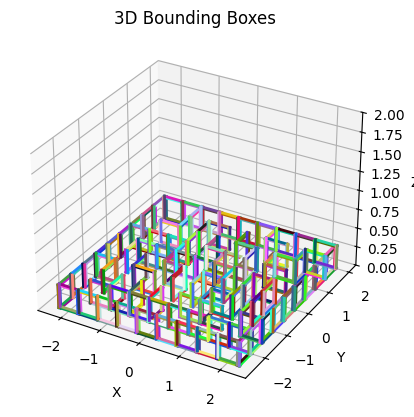

In [10]:
plot_3d_boxes(mins, maxs)

In [13]:
threshold = 1
final_mins, final_maxs = merge_irrelevant_boxes(np.array([.1, .1, .1]), np.array([1, 1, 1]), mins, maxs, threshold)

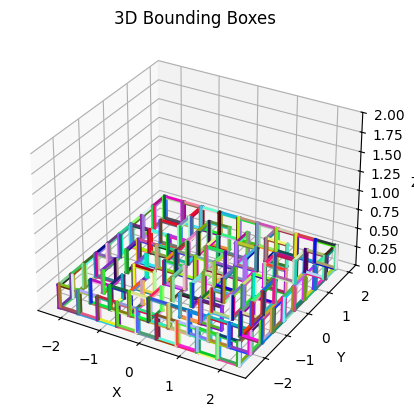

In [14]:
plot_3d_boxes(final_mins, final_maxs)